### Simulate adoption

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# increase plot resolution
mpl.rcParams["figure.dpi"] = 150

In [2]:
def gen_y_discrete(n, lmd):  # lambda is reserved in python
    return (np.random.uniform(size=n) < lmd).sum()

In [3]:
Nsim = 10000
np.random.seed(1234)
lmd = np.random.uniform(low=0.01, high=0.50, size=Nsim)
n = 100  # sample size for survey

In [4]:
simDF = pd.DataFrame({"y": 0, "lmd": lmd})
simDF


,y,lmd
0,0,0.103845
1,0,0.314833
2,0,0.224487
3,0,0.394826
4,0,0.392188
...,...,...
9995,0,0.422066
9996,0,0.311498
9997,0,0.081810
9998,0,0.355754


In [6]:
for i in range(Nsim):
    simDF.loc[i, "y"] = gen_y_discrete(n, lmd[i])

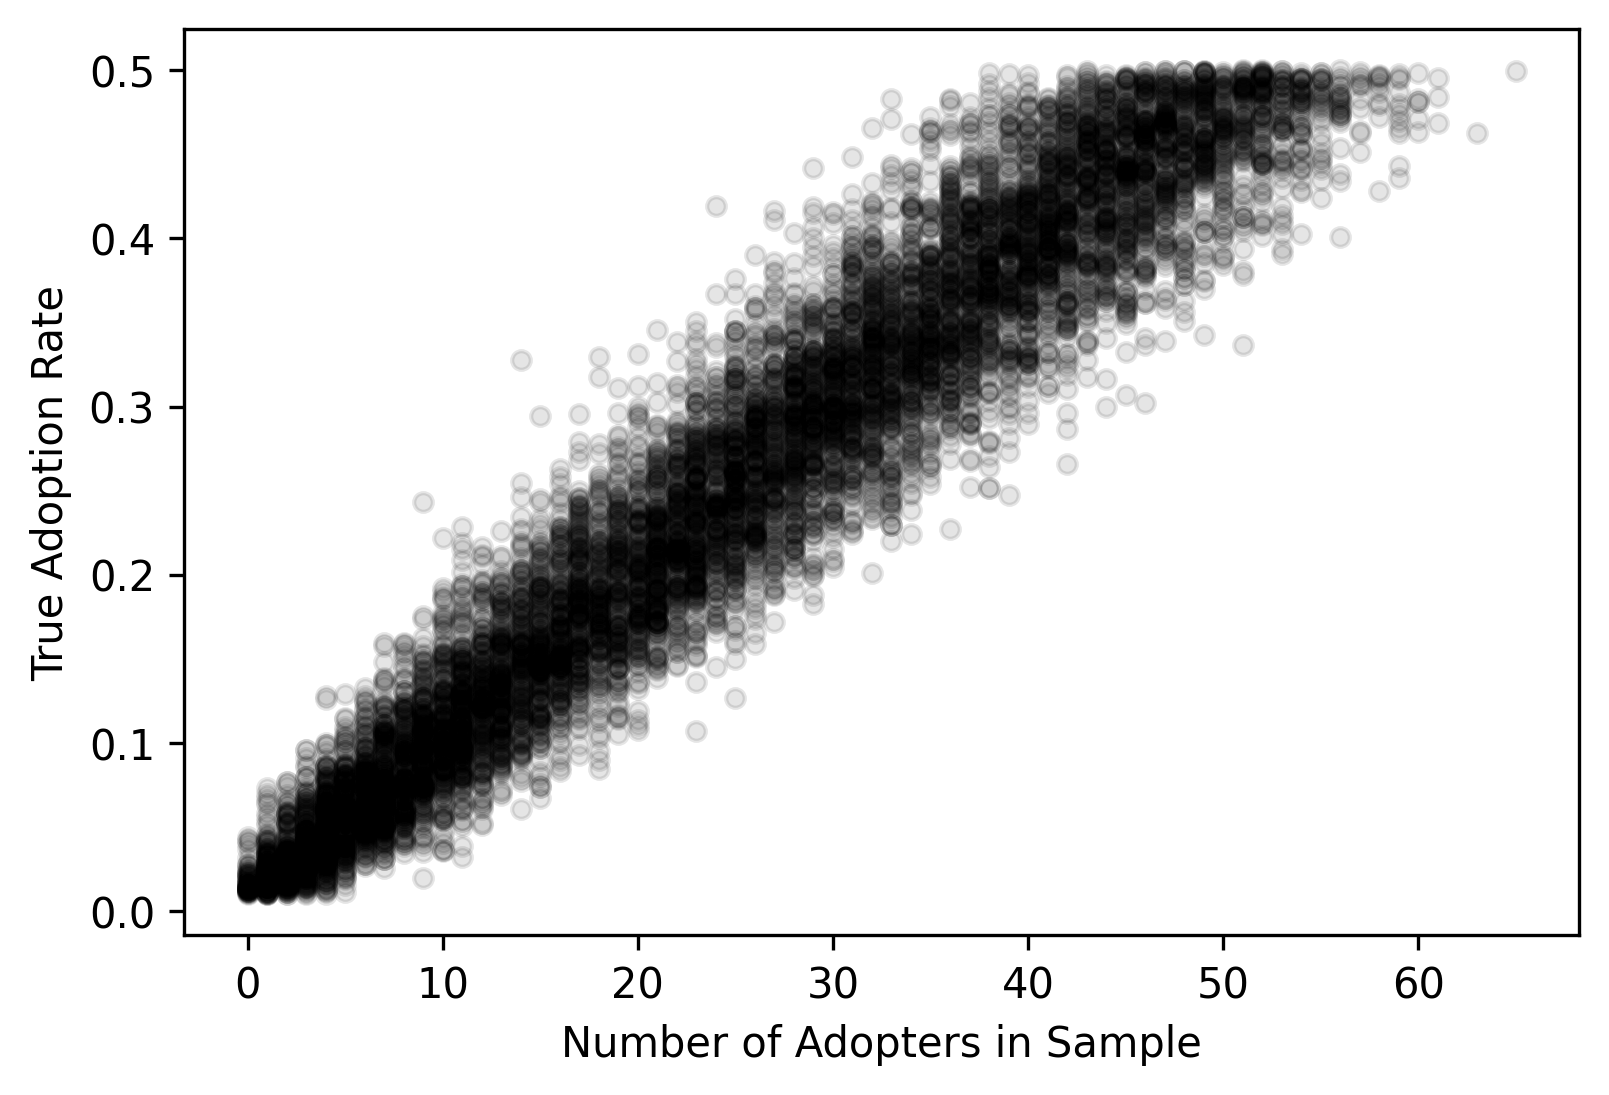

In [9]:
fig = simDF.plot.scatter(x="y", y="lmd", color="black", alpha=0.1)
fig.set_xlabel("Number of Adopters in Sample")
fig = fig.set_ylabel("True Adoption Rate")

### One survey sample says 20 adopters - what are plausible values of p?

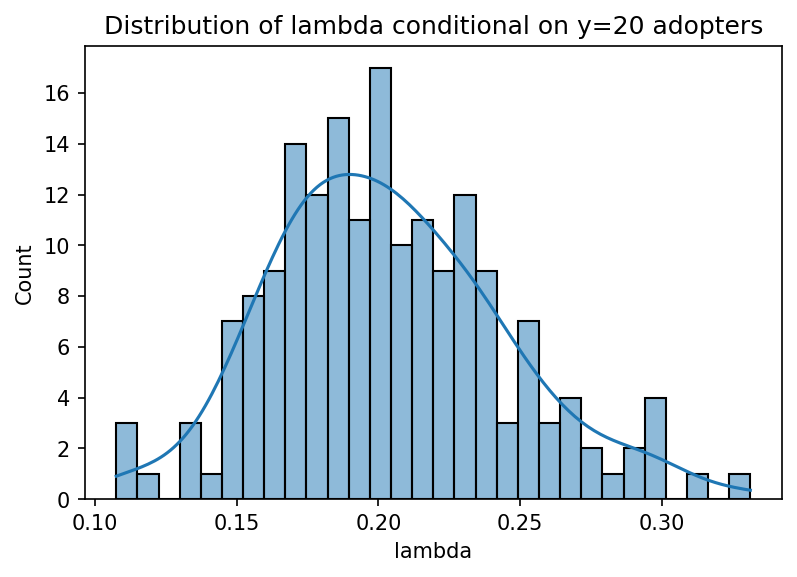

In [12]:
fig = sns.histplot(
    simDF.loc[simDF.y == 20, "lmd"],
    kde=True,
    bins=30,
)
fig = fig.set(
    xlabel="lambda", title="Distribution of lambda conditional on y=20 adopters"
)

### One survey sample says 10 adopters - what are plausible values of lambda?


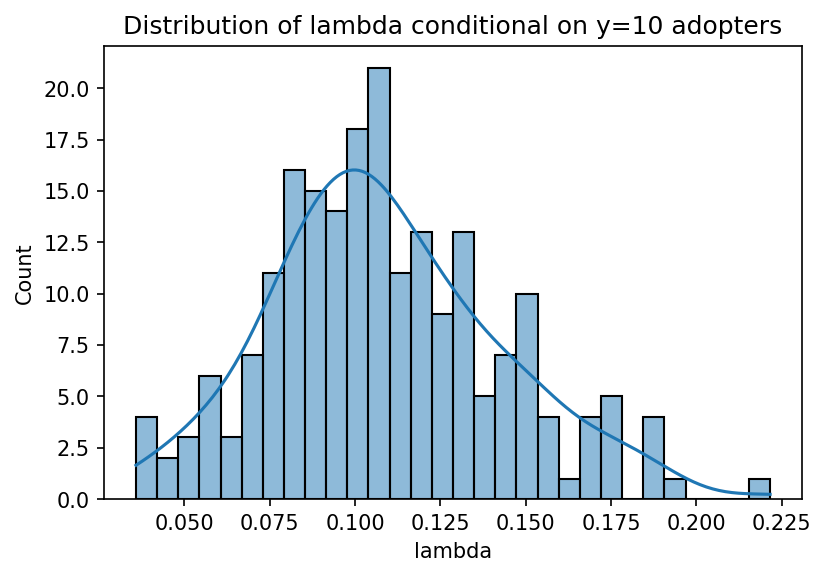

In [13]:
fig = sns.histplot(
    simDF.loc[simDF.y == 10, "lmd"],
    kde=True,
    bins=30,
)
fig = fig.set(
    xlabel="lambda", title="Distribution of lambda conditional on y=10 adopters"
)

### Calculate the probability that the true adotion rate is larger than 30%

In [14]:
yObs = 20
pUnder = 0.3
tmp = simDF.query(f"y == {yObs}")
probP = (tmp.lmd > pUnder).sum() / tmp.shape[0]
probP.round(5)

0.01111

### What if the true lambda=0.20

In [10]:
lambda0 = 0.20
lambdahat = np.zeros(Nsim, dtype=float)  # make sure lambdahat is of type float

In [11]:
for i in range(Nsim):
    lambdahat[i] = gen_y_discrete(n, lambda0) / n

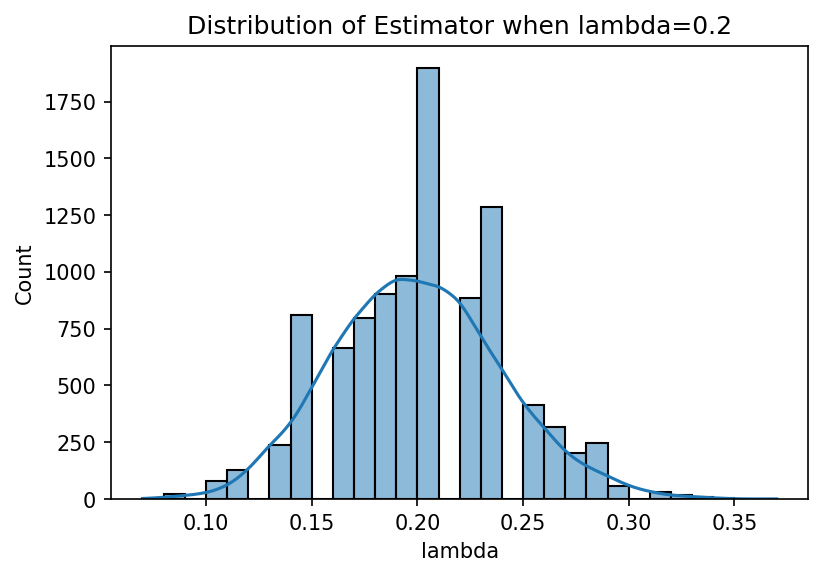

In [12]:
fig = sns.histplot(
    lambdahat,
    kde=True,
    bins=30,
)
fig = fig.set(xlabel="lambda", title="Distribution of Estimator when lambda=0.2")

## Plot beta posterior distrubtion

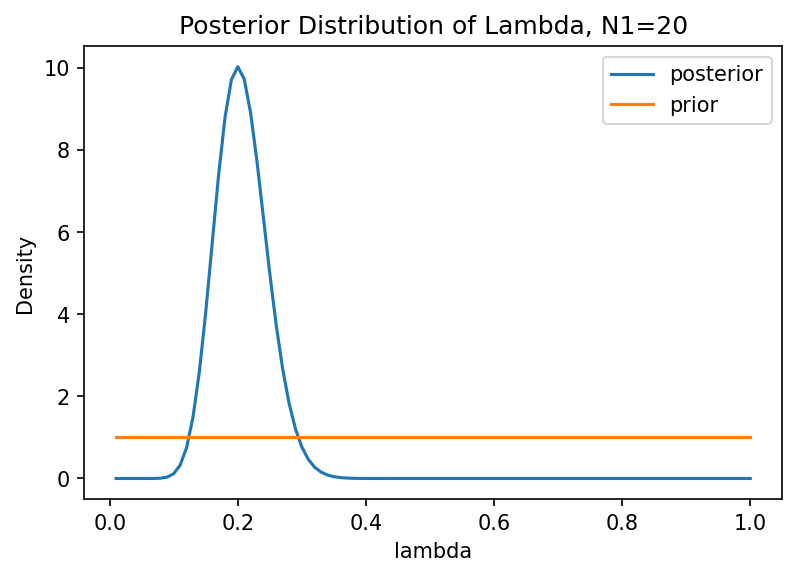

In [13]:
N1 = 20
N = 100
lambdaSeq = np.arange(0.01, 1.01, 0.01)

fig = (
    pd.DataFrame()
    .assign(posterior=stats.beta.pdf(lambdaSeq, N1 + 1, N - N1 + 1), prior=1)
    .set_index(lambdaSeq) 
    .plot()
)
fig = fig.set(
    title="Posterior Distribution of Lambda, N1=20", xlabel="lambda", ylabel="Density"
)

## Bayesian AB

In [14]:
# data - number comes from slide 23 from week 1
yA = 317
nA = 10000
yB = 152
nB = 5000

# parameters for the prior beta function of click through rate
# this prior is heavily weighted towards 0 because we know that 
# CTR are usually quite small
a0 = 1
b0 = 20

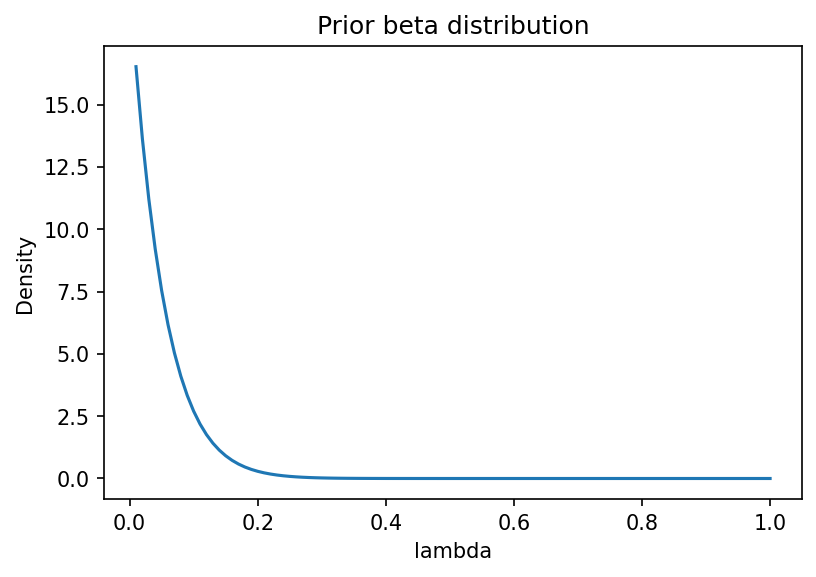

In [15]:
fig = (
    pd.DataFrame()
    .assign(lmb=lambdaSeq, prior=stats.beta.pdf(lambdaSeq, a0, b0))
    .plot(x="lmb", y="prior", legend=None)
)
fig = fig.set(
    title="Prior beta distribution", xlabel="lambda", ylabel="Density"
)

In [16]:
# posterior draws of CTR for A and B
nSim = 10000
np.random.seed(1234)
lambdaAPost = np.random.beta(yA + a0, nA - yA + b0, size=nSim)
lambdaBPost = np.random.beta(yB + a0, nB - yB + b0, size=nSim)
deltaPost = lambdaAPost - lambdaBPost
ProbDeltaPos = (deltaPost > 0).sum() / nSim
ProbDeltaPos # as shown in slide 26 from week 1

0.6608

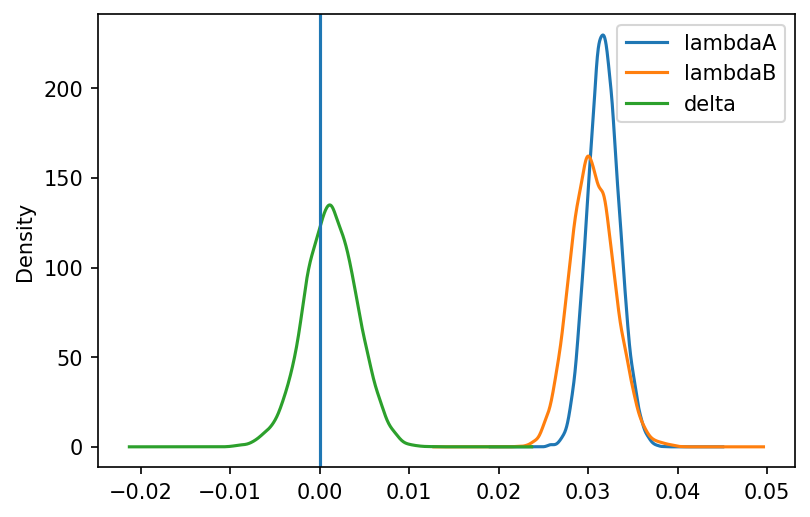

In [17]:
postDF = pd.DataFrame().assign(
    lambdaA=lambdaAPost, lambdaB=lambdaBPost, delta=deltaPost
)

fig = postDF.plot.kde()
fig = plt.axvline(0)

## Posterior Loss

In [18]:
def lossF(choice, lA, lB):

    if choice == "A":
        loss = np.mean((lB - lA) * (lB > lA))
    else:
        loss = np.mean((lA - lB) * (lA > lB))

    return loss


lossA = lossF("A", lambdaAPost, lambdaBPost)
lossB = lossF("B", lambdaAPost, lambdaBPost)
print(lossA.round(5), lossB.round(5))

0.00068 0.0019


## Plot Mu Post

In [6]:
mu = 1.0
sigma = 1.0
N = 100
np.random.seed(1234)
y = np.random.normal(mu, sigma, N)

In [7]:
y.mean()

1.0351122831254365

In [8]:
def postDens(y, sigma, mu0, sigma0):

    N = len(y)
    muMin = 0.0
    muMax = 2.0
    muSeq = np.arange(muMin, muMax + 0.01, 0.01)

    precPost = (N / (sigma ** 2)) + (1.0 / (sigma0 ** 2))
    mnPost = ((y.sum() / (sigma ** 2)) + (mu0 / (sigma0 ** 2))) / precPost

    return pd.DataFrame().assign(
        mu=muSeq,
        Density=stats.norm.pdf(muSeq, loc=mnPost, scale=np.sqrt(1.0 / precPost)),
        mu0=mu0,
        sigma0=sigma0,
    )

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

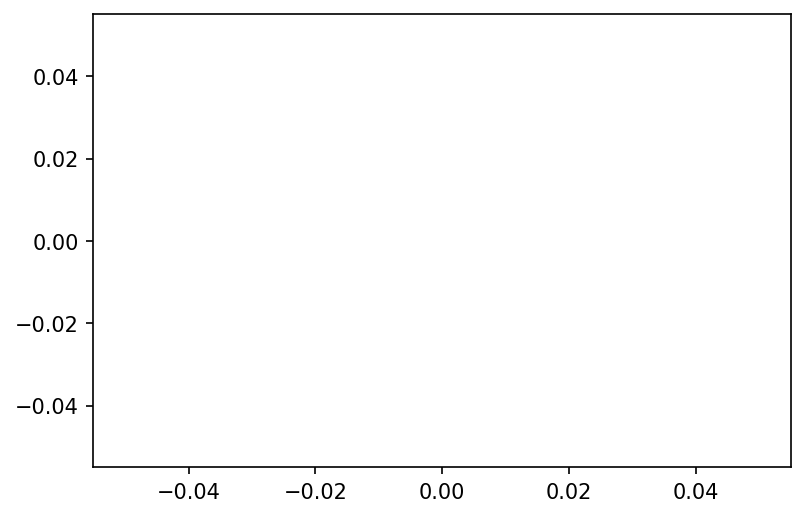

In [9]:
df = pd.concat([postDens(y, sigma, 0, s) for s in [10.0, 0.5, 0.25, 0.1]], axis=0)
df.sigma0 = df.sigma0. astype("category")

# 其他环境都不报错 就你报错 就你优秀
sns.lineplot(x="mu", y="Density", hue="sigma0", data=df)
fig = plt.axvline(1)

